In [25]:
import numpy as np
import pandas as pd
import torch
import os
from src.speech_classification.audio_processing import AudioPreprocessorFbank, SpeechCommandsDataCollector
from src.speech_classification.pytorch_conv_lstm import LstmNet
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:

wanted_words = ['bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'four', 'go', 'happy', 'house', 'left', 'marvin',
                'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two',
                'up', 'wow', 'yes', 'zero']
wanted_words_tanh_transition = ['a_a', 'a_i', 'a_u', 'a_o', 'a_e',
                                'i_a', 'i_i', 'i_u', 'i_o', 'i_e',
                                'u_a', 'u_i', 'u_u', 'u_o', 'u_e',
                                'o_a', 'o_i', 'o_u', 'o_o', 'o_e',
                                'e_a', 'e_i', 'e_u', 'e_o', 'e_e']

wanted_words_combined = wanted_words_tanh_transition


model_settings = {
    'dct_coefficient_count': 26,
    'label_count': len(wanted_words_combined) + 2,
    'hidden_reccurent_cells_count': 64,
    'winlen': 0.04,
    'winstep': 0.04
}

save_dir = r'C:\Study\SpeechAcquisitionModel\models\speech_classification'
if not os.path.exists(save_dir):
    try:
        os.makedirs(save_dir)
    except:
        pass
best_acc = 0.0
lowest_loss = 100.0
data_dir=r'C:\Study\SpeechAcquisitionModel\data\raw\Simple_transitions\02_25_2019_03_29_PM_08'

preproc = AudioPreprocessorFbank(model_settings['dct_coefficient_count'], winlen=model_settings['winlen'], winstep=model_settings['winstep'])
data_iter = SpeechCommandsDataCollector(preproc,
                                        data_dir=data_dir,
                                        wanted_words=wanted_words_combined,
                                        testing_percentage=10,
                                        validation_percentage=10
                                        )

net_fname = r"C:\Study\SpeechAcquisitionModel\models\speech_classification\simple_lstm_03_27_2019_05_00_PM_acc_0.8711.pt"


# Final test accuracy
n_mini_batch_size = 100
d = data_iter.get_data(n_mini_batch_size, 0, 'testing')
data = d['x']
labels = d['y']
seq_lengths = d['seq_len']

# load best model
net = torch.load(net_fname)

data = torch.from_numpy(data).float()
labels = torch.from_numpy(labels).long()


pred, hidden, _ = net(data, seq_lengths)
test_loss = torch.nn.CrossEntropyLoss()(pred, labels)

print(test_loss.detach().numpy())

0.4210943


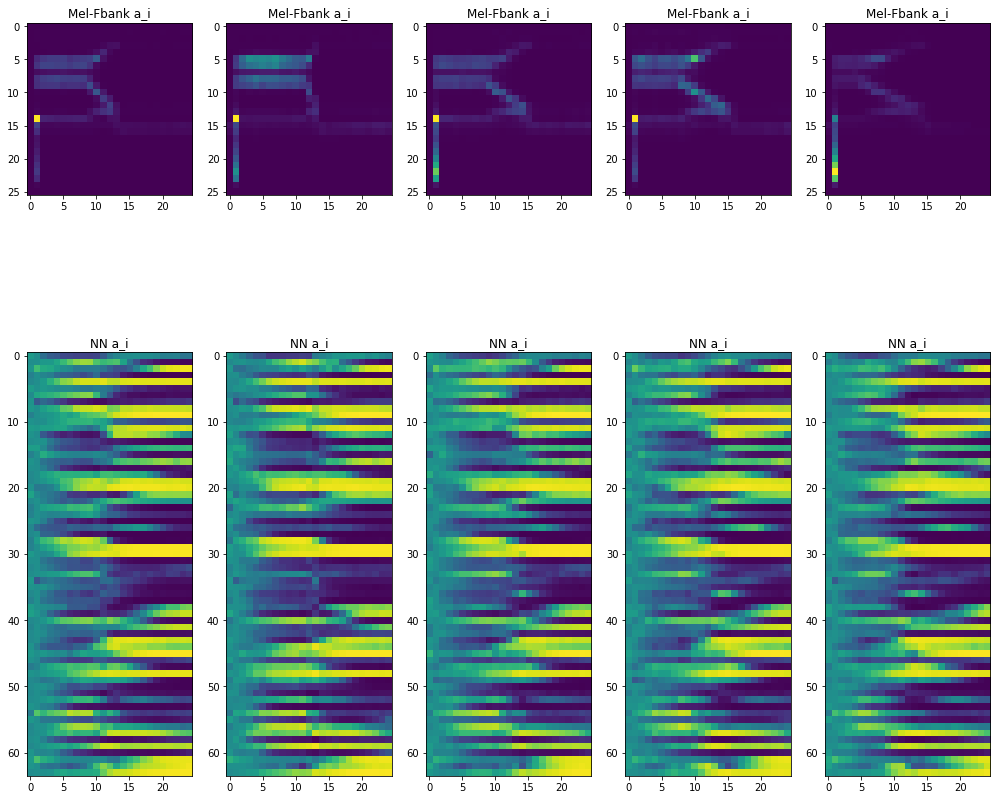

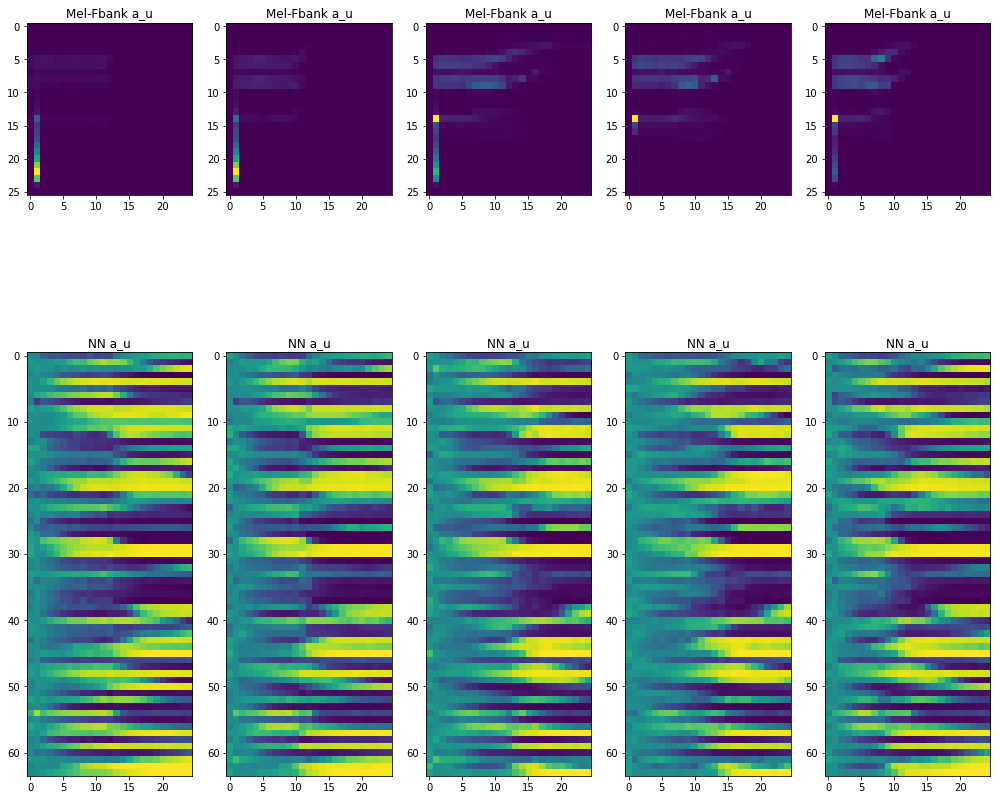

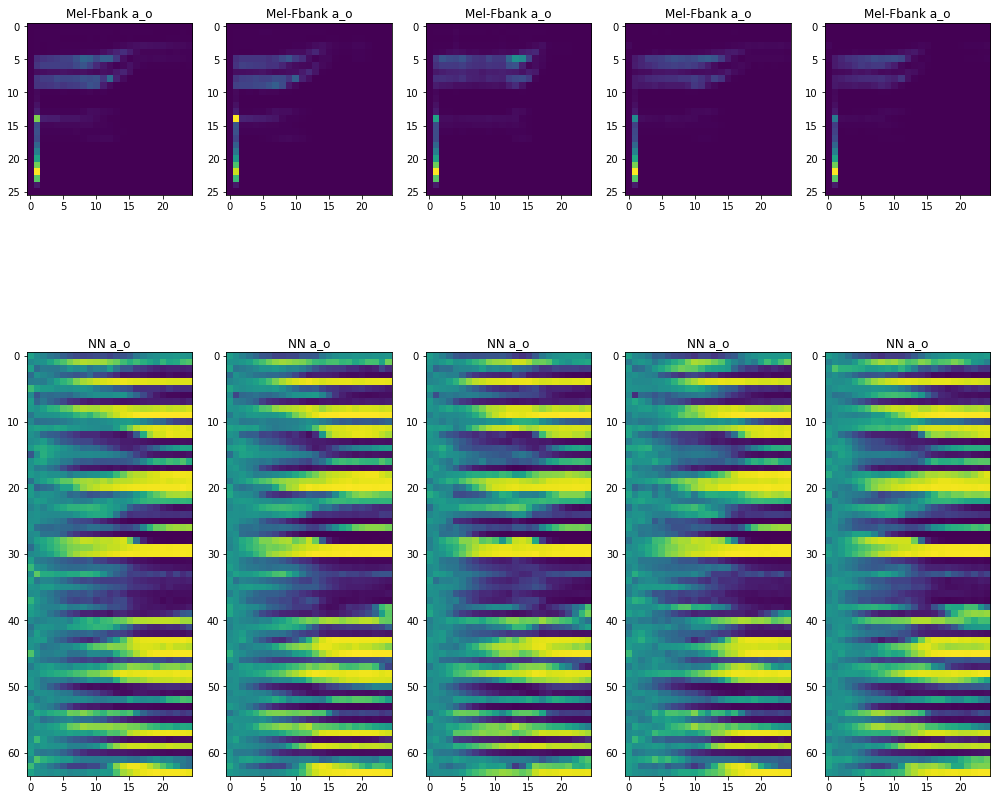

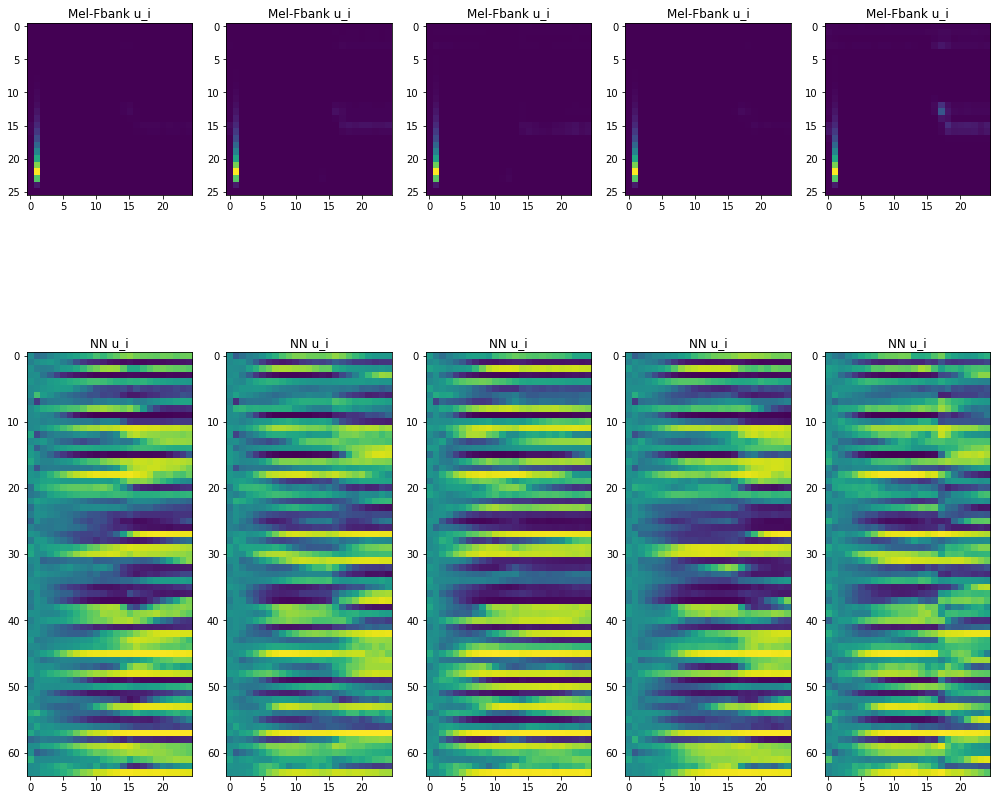

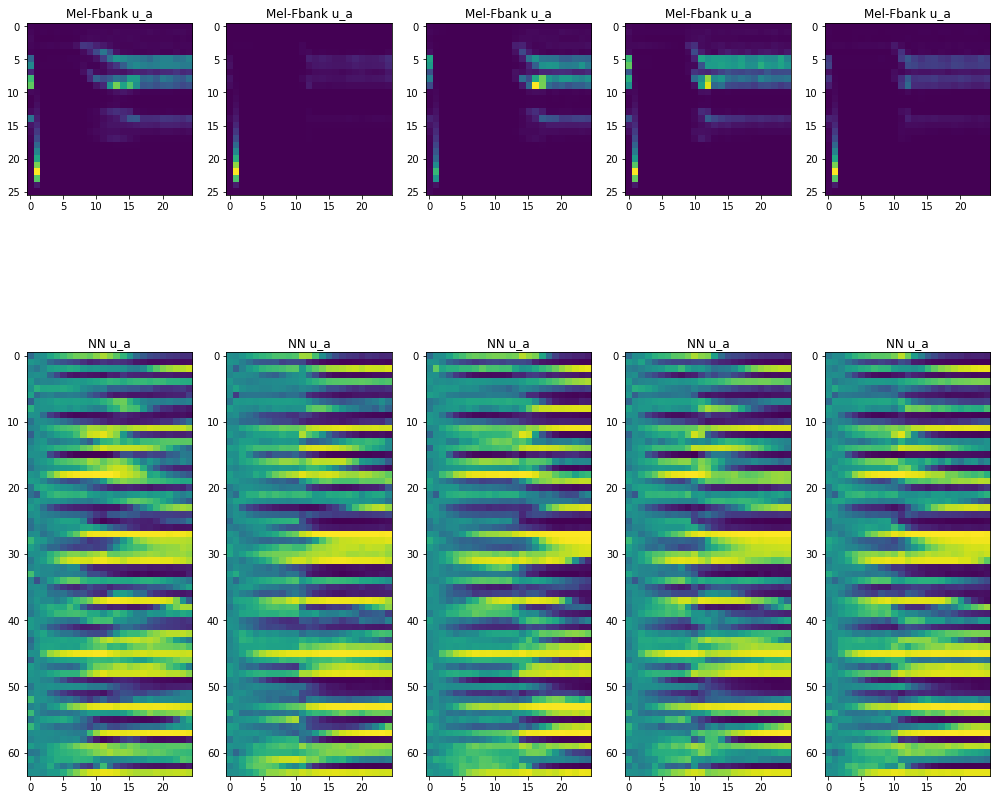

In [62]:
selected_words = ['a_i', 'a_u', 'a_o', 'u_i', 'u_a']
n_samples_per_class = 5
for w in selected_words:
    fnames = [f for f in os.listdir(os.path.join(data_dir, w)) if f.endswith('.wav') ]
    selected_fnames = [os.path.join(data_dir, w) + '/' + f for f in random.sample(fnames, n_samples_per_class)]
    
    plt.figure(figsize=(14,14))
    for i, f in enumerate(selected_fnames):
        preprocessed = preproc(f)
        ax1 = plt.subplot(2, n_samples_per_class, i+1)
        ax1.imshow(preprocessed.T)
        plt.title("Mel-Fbank " + os.path.basename(w))
        
        ax2 = plt.subplot(2, n_samples_per_class, n_samples_per_class + i + 1)
        data = torch.from_numpy(preprocessed).float().unsqueeze(dim=0)
        pred, hidden, out = net(data, np.array([data.shape[1]]))
        ax2.imshow(out.detach().cpu().numpy().squeeze().T)
        plt.title("NN " + os.path.basename(w))
        
        
    plt.tight_layout()
